### Metrics implement

This notebook is based on my understanding to implement basic logic of each machine learning metrics that we would use many times, we use directly **sklearn.metrics** that to evaluate models' prediction, so here is just to implement each metric by hands.

In [31]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

x, y = load_iris(return_X_y=True)
x += np.random.normal(0, 10, size=x.shape)
x, y = x[:100, ], y[:100]

lr = LogisticRegression(C=1)
lr.fit(x, y)

prob = lr.predict_proba(x)
pred= lr.predict(x)

print(lr.score(x, y))

0.65


In [32]:
# first let's try to compute confusion matrix
conf_sk = metrics.confusion_matrix(y, pred)

print(conf_sk)

[[30 20]
 [15 35]]


In [33]:
# implement with confusion matrix
def compute_confusion(y, pred):
    true_label = 1
    false_label = 0
    
    tp = pred[y == true_label].tolist().count(true_label)   # how many truth in pred is also truth
    fp = pred[y == false_label].tolist().count(true_label)   # pred is truth but real is false
    tn = pred[y == false_label].tolist().count(false_label)    # pred is false and real is  false
    fn = pred[y == true_label].tolist().count(false_label)   # pred is false but real is true
    
    return np.array([[tn, fp], [fn, tp]])


conf = compute_confusion(y, pred)
print(conf)

[[30 20]
 [15 35]]


In [34]:
# let's compute recall score

def recall(conf):
    tp, fn = conf[1, 1], conf[1, 0]
    return tp / (tp + fn)

score_recall = metrics.recall_score(y, pred)

print("sklearn recall: ", metrics.recall_score(y, pred))
print("My recall: ", recall(conf))

sklearn recall:  0.7
My recall:  0.7


In [35]:
# precision
def precision(conf):
    tp, fp = conf[1, 1], conf[0, 1]
    return tp / (tp + fp)

print("sklearn recall: ", metrics.precision_score(y, pred))
print("My recall: ", precision(conf))


sklearn recall:  0.6363636363636364
My recall:  0.6363636363636364


### ROC curve

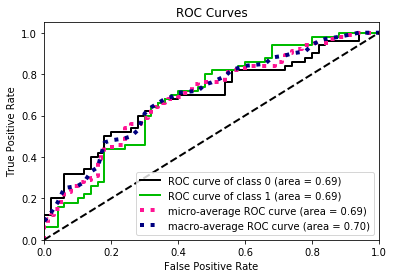

In [36]:
# use scikitplot to plot roc curve
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_roc

plot_roc(y, prob)

plt.show()

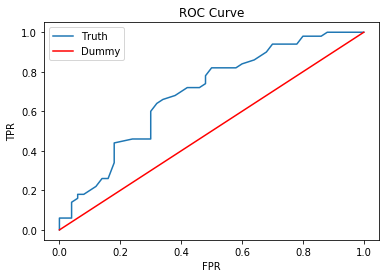

In [52]:
def tpr(conf):
    tp, fn = conf[1, 1], conf[1, 0]
    return tp / (tp + fn)

def fpr(conf):
    fp, tn = conf[0, 1], conf[0, 0]
    return fp / (fp + tn)

def plot_roc_curve(y, prob, plot_curve=True, return_value=False):
    thre = np.linspace(0, 1, 100)
    true_label = 1
    
    false_positive_rate = []
    true_positive_rate = []
    
    for t in thre:
        pred = (prob[:, 1] > t).astype(int)
        conf = compute_confusion(y, pred)
        
        true_positive_rate.append(tpr(conf))
        false_positive_rate.append(fpr(conf))
        

    dummy_x_col, dummy_y_col = thre, thre
    if plot_curve:
        plt.plot(false_positive_rate, true_positive_rate, label='Truth')
        
        plt.plot(dummy_x_col, dummy_y_col, "r", markersize=2, label='Dummy')
        
        plt.legend()
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC Curve')
        
        plt.show()
    if return_value:
        return true_positive_rate, false_positive_rate

plot_roc_curve(y, prob)

### LogLoss

**LogLoss** is used to evaluate **loss** of **Logistic Regression** algorithm fitting loss that opitimizer to optimize, the function is: `sum(- y * log(y_hat) - (1 - y) * log(1 - y_hat))`. By default `sklearn` log_loss is will normalize result. 

In [53]:
def log_loss(y, prob):
    if len(prob.shape) > 1 and prob.shape[1] > 1:
        prob = prob[:, 1]
        
    return np.average(- y * np.log(prob) - (1 - y) * np.log(1 - prob))

sk_log_loss = metrics.log_loss(y, prob)

print("Sklearn log loss: ", sk_log_loss)
print("My log loss: ", log_loss(y, prob))

Sklearn log loss:  0.6259778466668365
My log loss:  0.6259778466668365


### Decision Tree feature selection

What is a feature to select for DT? we would more like to select a feature that could split these dataset into a more **pure** dataset that means for each leaf there are more likely to be same label, so this is goal.

We have **Entropy** to describe how **pure** that dataset is, function is - sum(prob * log(prob)), if the leaf is **pure** then class probability is 1, then entropy is 0, also we have base **Entropy** before we do any split, so `information gain = Ent(y) - Ent(y|feature)`, so base entropy is same, if we have more pure leaf mean entropy is smaller, so the information gain is bigger, so we would choose **Bigger information gain**.

As for **CART** that will use **Gini index** to select feature, `gini index = 1 - sum(pi**2)`, gini value is to describe that if we want to choose 2 samples in a dataset that they are from different classes, so if we have less value for gini that means that this group is more likely to be more **pure**, so **Gini index** is **smaller** to split feature.

As for to choose **information gain** or **gini index** could be used as a parameter tuning, why to choose **gini** is that it's computation less, as **entropy** will use `log` in the computation funciton. The real world, they are similiar should be tuned by searching.

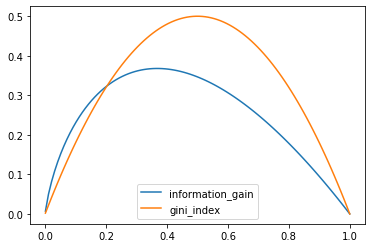

In [57]:
# let's try to plot information gain and gini index
def information_gain(prob):
    return - prob * np.log(prob)

def gini_index(prob):
    return 1 - np.sum([prob**2, (1 - prob)**2], axis=0)


sample_prob = np.linspace(0.001, 1, 100)

plt.plot(sample_prob, information_gain(sample_prob), label='information_gain')
plt.plot(sample_prob, gini_index(sample_prob), label='gini_index')

plt.legend()
plt.show()